## RTML Final 2021 Question 6

## Question 6, 30 points

Based on your existing DQN implementation, implement the double DQN and self-play training method
you just described. After some training (don't spend too much time on training -- again, we just want to see that the model can
learn), show the result you playing a game against your learned agent.

In [1]:
import math, random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

import importlib
from collections import defaultdict
import torch
import numpy

# Select GPU or CPU as device

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [2]:
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [3]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

### Define model

In [4]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, n_action)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(n_action)
        return action

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Define loss

In [5]:
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Define Train Function

######### modify here ########### is where i added lines of code

In [6]:
def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    
    ######### modify here ###########
    state = obs.reshape(-1)

    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        
        # input action into state
#         next_obs, reward, done, _ = env.step(action)
        next_obs, reward, done = env.step(action)

        ######### modify here ###########
        next_state = next_obs.reshape(-1)
        
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            
            ######### modify here ###########
            state = obs.reshape(-1)
            
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: 
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

### Plot

In [7]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

Agent training (episode5001) Avg Reward -0.017196560687862426: 100%|██████████| 5001/5001 [01:04<00:00, 77.84it/s]


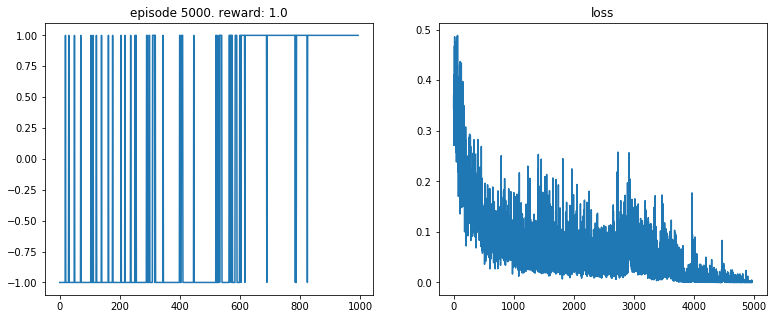

In [15]:
import importlib
game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()
env.reset()

n_state = 27

n_action = 9

episode = 5000

# model = DQN(n_state = n_state, n_action = n_action).to(device)

current_model = DQN(n_state = n_state, n_action = n_action).to(device)
target_model = DQN(n_state = n_state, n_action = n_action).to(device)
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)
update_target(current_model, target_model)

current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = episode, batch_size=32, gamma = 0.99)

In [16]:
torch.save(current_model.state_dict(), 'weights_5000.pth')

### Show the result you playing a game against your learned agent.

In [8]:
import importlib
game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()
env.reset()

n_state = 27

n_action = 9

current_model = DQN(n_state = n_state, n_action = n_action).to(device)
current_model.load_state_dict(torch.load('weights_5000.pth'))


<All keys matched successfully>

In [9]:
def play(model, player):
    done = False
    state = env.reset()
    state = state.reshape(-1)
    
    while(not done):
        if env.to_play() == player:
            available_action = env.legal_actions()
            print("available action:", available_action)
            action = env.human_to_action()
            # These will appear to select actions
            # Enter the row (1,2,3):
            # Enter the colume (1,2,3):
            next_state, reward, done = env.step(action)
            next_state = next_state.reshape(-1)
            print("Beau's turn")
            print(env.action_to_string(action))
        else:
            action = model.act(state, epsilon_final)
            next_state, reward, isq_done = env.step(action)
            next_state = next_state.reshape(-1)
            print("Model's turn")
            print(env.action_to_string(action))
        
        env.render()
        time.sleep(0.03)
        state = next_state

In [10]:
# I play as O 
play(current_model,1)

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Beau's turn
Play row 1, column 3
   |   | O 
---+---+---
   |   |   
---+---+---
   |   |   
Model's turn
Play row 3, column 1
   |   | O 
---+---+---
   |   |   
---+---+---
 X |   |   
available action: [0, 1, 3, 4, 5, 7, 8]
Beau's turn
Play row 1, column 1
 O |   | O 
---+---+---
   |   |   
---+---+---
 X |   |   
Model's turn
Play row 2, column 1
 O |   | O 
---+---+---
 X |   |   
---+---+---
 X |   |   
available action: [1, 4, 5, 7, 8]
Beau's turn
Play row 1, column 2
 O | O | O 
---+---+---
 X |   |   
---+---+---
 X |   |   


In [13]:
# I play as X
play(current_model,-1)

Model's turn
Play row 2, column 2
   |   |   
---+---+---
   | O |   
---+---+---
   |   |   
available action: [0, 1, 2, 3, 5, 6, 7, 8]
Beau's turn
Play row 1, column 2
   | X |   
---+---+---
   | O |   
---+---+---
   |   |   
Model's turn
Play row 2, column 1
   | X |   
---+---+---
 O | O |   
---+---+---
   |   |   
available action: [0, 2, 5, 6, 7, 8]
Beau's turn
Play row 1, column 1
 X | X |   
---+---+---
 O | O |   
---+---+---
   |   |   
Model's turn
Play row 3, column 3
 X | X |   
---+---+---
 O | O |   
---+---+---
   |   | O 
available action: [2, 5, 6, 7]
Beau's turn
Play row 1, column 3
 X | X | X 
---+---+---
 O | O |   
---+---+---
   |   | O 
